# Systematic analysis of biases applied on NFB ADHD

This method takes advantage of studies technical and methodological high heterogeneity rather than suffering from it. Indeed, the domain of Neurofeedback (NFB) applied to ADHD children is characterized by a clinical litterature that is tremendously heterogeneous. Since we supposed that the methodologcial and technical choices made by authors may impact the efficay of NFB, we propose here to identify which of the factors independently influence the reported within-subject effect size (ES) thanks to adequate statistical tools (weighted least squares, regularization LASSO and a decision tree). See *Bussalb et al*.

## Import raw data

If you have not installed the ```source_assess_NFB_efficacy``` package (see ```README.md```) do not forget to uncomment and change the path given in ```sys.path.append```. It corresponds to the path where the modules are. Besides, make sure the requirements noted in ```requirements.txt``` are fulfilled. The csv file containing all required information (*values_total_meta_analysis_all_factors.csv*) is available. 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import random
import sys

from IPython.display import display

# Add the path where the packages are
# sys.path.append(r"C:\Users\Aurore Bussalb\Desktop\github_repo")
import source_assess_NFB_efficacy.systematic_analysis_of_biases.import_csv_for_factors as icf
import source_assess_NFB_efficacy.systematic_analysis_of_biases.perform_systematic_analysis_of_bias as saob

%matplotlib inline

# Import data from a csv file
df_parents, df_teachers = icf.import_csv('values_total_meta_analysis_all_factors.csv')
df = pd.concat([df_parents, df_teachers])

## Compute the within effect size

We compute the within subject effect size (Cohen, 1988) for each clinical scale available in the articles included in the analysis. 

In [14]:
# Cohen J. (1988). Statistical Power Analysis for the Behavioral Sciences
df['effect_size_NFB'] = df[['mean_post_test_NFB','mean_pre_test_NFB','std_post_test_NFB','std_pre_test_NFB']
                                ].apply(lambda row:saob.effect_size_within_subjects(**row), axis=1) 

## Preprocess factors 

The pre-processing of factors for the analysis includes the following steps: factors for which there are too many missing observations, arbitrarily set to more than 20% of the total of observations, are removed from the analysis. Furthermore, if a factor has more than 80% similar observations it is removed as well. Categorical variables are coded as dummies meaning that the presence of the factor is represented by a 1 and its absence by 0. All variables are standardized, except when the decision tree is performed.

In [15]:
X, X_non_standardized = saob.preprocess_factors(df)

The type of thresholding, the use of a transfer card, the protocol beta up in frontal areas, the EEG quality equal to 3 and the presence of a control group are removed from the analysis.

C:\Users\Aurore Bussalb\Programing\Anaconda3\envs\NFB-efficacy-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of the within ES across studies')

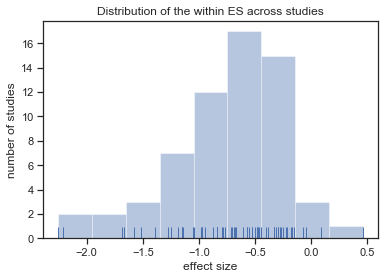

In [16]:
# Detect outliers
plt.figure()  
sns.distplot(df['effect_size_NFB'].values, kde=False, rug=True)
plt.xlabel('effect size')
plt.ylabel('number of studies')  
plt.title('Distribution of the within ES across studies')  

No outlier has been detected.

C:\Users\Aurore Bussalb\Programing\Anaconda3\envs\NFB-efficacy-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

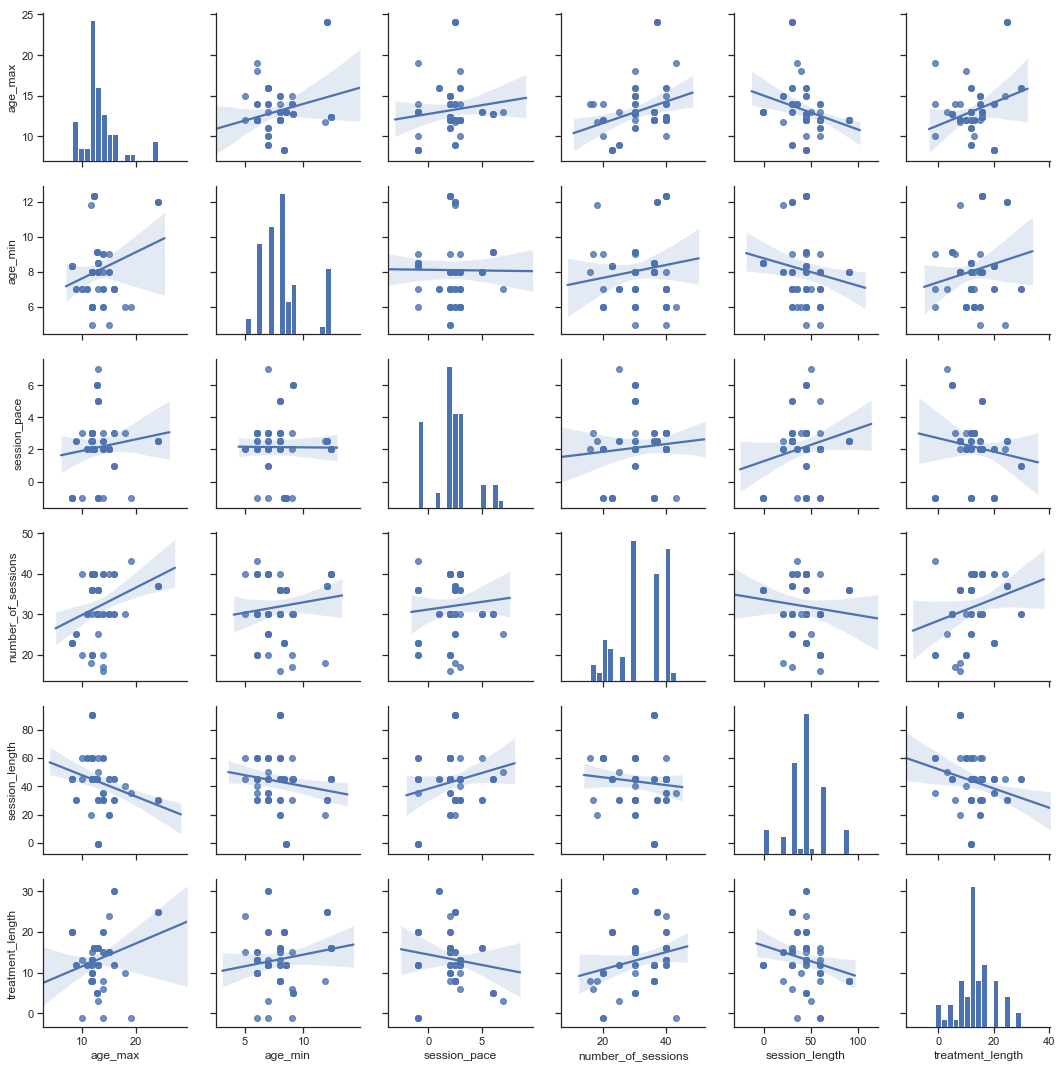

In [17]:
# Correlation plot between continuous variables
X_continuous_variables = X_non_standardized[['age_max', 'age_min', 'session_pace', 'number_of_sessions', 
                                      'session_length', 'treatment_length']] 
plt.figure()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(X_continuous_variables, kind = "reg", diag_kws=dict(bins=15))   

Continuous variables seem not correlated.

Text(0,0.5,'standardized values')

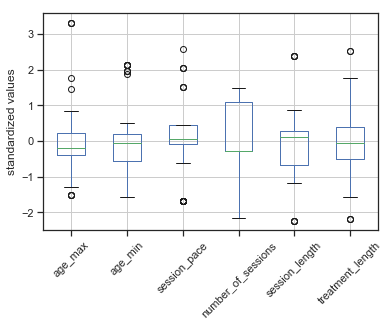

In [18]:
# Boxplots to assess the spread of the factors 
plt.figure()
ax = X.boxplot(['age_max', 'age_min', 'session_pace', 'number_of_sessions', 'session_length',
                'treatment_length'], rot=45)
ax.set_ylabel('standardized values')

Number of sessions, session and treatment length are more variable across studies than the age of included children and session space. 

In order to prevent any bias, it is possible to hide factor names during the analysis: 

In [ ]:
# Run this cell to hide variable names
X.columns = random.sample(range(1, len(X.columns)+1), len(X.columns))
X_non_standardized.columns = X.columns

## First method: Weighted Least Squares (WLS)

The aim of the WLS is to estimate the regression coefficients of a **linear** and **weighted** model. A significant coefficient (meaning significantly different from 0) indicates that the associated factor has probably an influence on NFB efficacy and the sign of the coefficient indicates the direction of the effect. 

In [19]:
# WLS
summary = saob.weighted_linear_regression(df, X, df['effect_size_NFB'])
display(summary)

Moment matrix is invertible


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        effect_size_NFB   R-squared:                       0.822
Model:                            WLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     10.24
Date:                Fri, 27 Jul 2018   Prob (F-statistic):           2.81e-10
Time:                        18:25:54   Log-Likelihood:                -10.320
No. Observations:                  62   AIC:                             60.64
Df Residuals:                      42   BIC:                             103.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -0.6835      0.045    -15.044      0.000      -0.775      -0.592
number_of_sessions                            -0.0075      0.074     -0.102      0.919      -0.157       0.142
age_min                                       -0.0545      0.061     -0.900      0.373      -0.177       0.068
age_max                                       -0.0902      0.062     -1.445      0.156      -0.216       0.036
session_pace                                  -0.2489      0.058     -4.304      0.000      -0.366      -0.132
session_length                                 0.1718      0.122      1.410      0.166      -0.074       0.418
treatment_length                               0.5654      0.076      7.405      0.000       0.411       0.719
theta_down_yes                                -0.2955      0.115     -2.570      0.014      -0.528      -0.063
EOG_correction_yes                            -0.0782      0.096     -0.818      0.418      -0.271       0.115
EEG_quality_two                               -0.3608      0.070     -5.156      0.000      -0.502      -0.220
SCP_yes                                       -0.0988      0.146     -0.676      0.503      -0.394       0.196
beta_up_central_yes                           -0.0266      0.075     -0.355      0.724      -0.178       0.124
more_than_one_active_electrode_yes             0.0634      0.070      0.912      0.367      -0.077       0.204
randomization_yes                              0.0069      0.071      0.098      0.922      -0.136       0.149
transfer_phase_yes                             0.2681      0.121      2.216      0.032       0.024       0.512
pblind_yes                                     0.1027      0.049      2.087      0.043       0.003       0.202
SMR_yes                                       -0.0634      0.076     -0.829      0.412      -0.218       0.091
on_drugs_yes                                   0.0686      0.084      0.819      0.418      -0.100       0.238
IRB_yes                                       -0.2916      0.073     -3.994      0.000      -0.439      -0.144
artifact_correction_based_on_amplitude_yes     0.1549      0.073      2.121      0.040       0.008       0.302
==============================================================================
Omnibus:                        0.286   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.325
Skew:                          -0.152   Prob(JB):                        0.850
Kurtosis:                       2.817   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covarianc

We can rely on the WLS results, because the following assumptions are satisfied:
* The moment matrix is invertible, 
* There is no apparent correltion between the continuous independent variables,
* The fit is significant: ```prob(F-statistic) = 2.81e-10```,
* The residuals are normally distributed: ```skew = -0.152```, ```kurtosis = 2.817``` and the Omnibus test ```(prob(Omnibus) = 0.867)```. 

In order to assess the impact of the weights on the results, we compare the WLS results with those obtained with the Ordinary Least Squares (OLS).

In [20]:
# Run the OLS to compare results
summary_ols = saob.ordinary_linear_regression(X, df['effect_size_NFB'])
display(summary_ols)

Moment matrix is invertible


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        effect_size_NFB   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     3.307
Date:                Fri, 27 Jul 2018   Prob (F-statistic):           0.000616
Time:                        18:25:56   Log-Likelihood:                -18.940
No. Observations:                  62   AIC:                             77.88
Df Residuals:                      42   BIC:                             120.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -0.7163      0.051    -14.134      0.000      -0.819      -0.614
number_of_sessions                             0.0531      0.096      0.553      0.583      -0.140       0.247
age_min                                       -0.0112      0.078     -0.143      0.887      -0.169       0.146
age_max                                       -0.0270      0.089     -0.304      0.762      -0.206       0.152
session_pace                                  -0.1973      0.074     -2.672      0.011      -0.346      -0.048
session_length                                 0.1359      0.145      0.940      0.353      -0.156       0.428
treatment_length                               0.4478      0.101      4.434      0.000       0.244       0.652
theta_down_yes                                -0.1889      0.143     -1.321      0.194      -0.477       0.100
EOG_correction_yes                          7.219e-05      0.124      0.001      1.000      -0.250       0.251
EEG_quality_two                               -0.2787      0.089     -3.128      0.003      -0.458      -0.099
SCP_yes                                       -0.0069      0.183     -0.038      0.970      -0.376       0.362
beta_up_central_yes                           -0.0309      0.096     -0.321      0.750      -0.225       0.163
more_than_one_active_electrode_yes             0.0833      0.089      0.937      0.354      -0.096       0.263
randomization_yes                              0.0472      0.092      0.512      0.611      -0.139       0.233
transfer_phase_yes                             0.2091      0.156      1.337      0.188      -0.106       0.525
pblind_yes                                     0.1160      0.056      2.075      0.044       0.003       0.229
SMR_yes                                        0.0245      0.092      0.265      0.792      -0.162       0.211
on_drugs_yes                                   0.0448      0.109      0.410      0.684      -0.175       0.265
IRB_yes                                       -0.2423      0.094     -2.589      0.013      -0.431      -0.053
artifact_correction_based_on_amplitude_yes     0.0698      0.085      0.822      0.416      -0.102       0.241
==============================================================================
Omnibus:                        1.986   Durbin-Watson:                   2.297
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.308
Skew:                          -0.063   Prob(JB):                        0.520
Kurtosis:                       3.700   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covarianc

Here again, the assumptions are satisfied.
Less factors are found significantly different from 0 with OLS.

## Second method: Least Absolute Shrinkage and Selection Operator (LASSO)

The second method is **linear** and incorporates **variable selection** in the linear model. A coefficient not set to zero must explain the model (so it may have an influence of NFB efficacy). The sign of the coefficient indicates the direction of the effect.

In [22]:
coeff, mse_test, alphas, alpha = saob.regularization_lassocv(X, df['effect_size_NFB'])
print('Tuning parameter found by CV', alpha)
display(coeff)     

Tuning parameter found by CV 0.012239706788976745


,Factors,Coefficients
0,number_of_sessions,0.000000
1,age_min,0.000000
2,age_max,0.000000
3,session_pace,-0.142704
4,session_length,0.000000
5,treatment_length,0.336681
6,theta_down_yes,-0.054924
7,EOG_correction_yes,0.000000
8,EEG_quality_two,-0.236874
9,SCP_yes,0.103292


Text(0.5,1,'Mean square error on the folds and the mean fold')

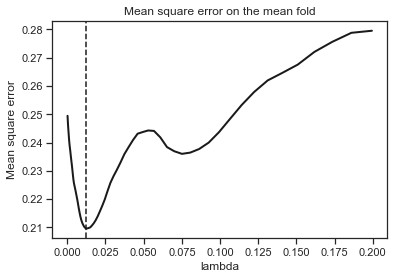

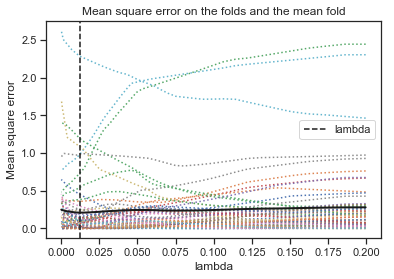

In [23]:
# Display results: see the better lambda
    
# MSE only on the mean fold
plt.figure()
plt.plot(alphas, mse_test.mean(axis=1),linewidth=2, color='k', label='lambda')
plt.axvline(alpha, linestyle='--', color='k', label='alpha: CV estimate')
plt.xlabel('lambda')
plt.ylabel('Mean square error')
plt.title('Mean square error on the mean fold')
        
# MSE only on all the folds
plt.figure()
plt.plot(alphas, mse_test, ':')
plt.plot(alphas, mse_test.mean(axis=1),linewidth=2, color='k')
plt.axvline(alpha, linestyle='--', color='k', label='lambda')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Mean square error')
plt.title('Mean square error on the folds and the mean fold')

Leave-one-out cross validation is applied to find the tuning parameter. The Mean Square Error (MSE) is computed on each test set. The tuning parameter correponds to the abscissa of the minimum value of the MSE on the mean fold. 

In [24]:
# Lasso with AIC criterion to compare results obtained with CV
coeff_aic = saob.regularization_lassoAIC(X, df['effect_size_NFB'])
display('Lasso results with AIC', coeff_aic) 

'Lasso results with AIC'

,Factors,Coefficients
0,number_of_sessions,0.000000
1,age_min,0.000000
2,age_max,0.000000
3,session_pace,-0.148969
4,session_length,0.000000
5,treatment_length,0.346813
6,theta_down_yes,-0.060717
7,EOG_correction_yes,0.000000
8,EEG_quality_two,-0.244807
9,SCP_yes,0.102793


When we determine the tuning parameter with the AIC criterion, we obtain the same results as those of the cross validation method.

## Third method: Decision Tree

The last method used is the decision tree: a **hierarchical** and **non-linear** method.

In [25]:
# Decision tree
saob.decision_tree(X_non_standardized, df['effect_size_NFB'])

R² decision tree 0.41362707482160765
